In [2]:
from raspy import *
from raspy.rasp import Seq, Sel, SOp, Key, Query
from raspy.visualize import draw_all, draw, draw_sel
from chalk import *
from colour import Color
from raspy.visualize import word

In [3]:
#Change aggreagation type to mean aggergation instead of summation
setAggType("mean")

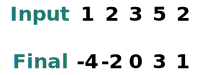

In [4]:
#Basic tests to see if RASPy installed and working
model = tokens - 5 + indices
model.input([1, 2, 3, 5, 2])

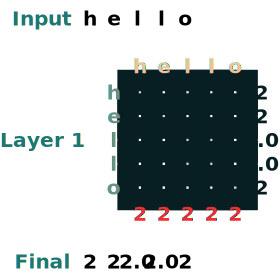

In [5]:
(key(tokens) == query(tokens)).value(2)

## Attempt to create addition of two numbers with mean aggreagation

In [6]:
short = ["t", "e", "s"]
long = ["l", "o", "n" , "g", "e", "r"]

before = (key(indices) < query(indices))

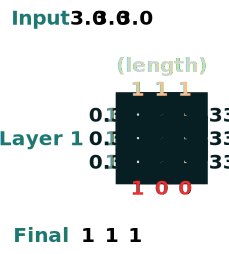

In [31]:
#Length function (Does not output integers, potentially problematic, seems to work with equivalence (i.e. 2.0 == 2) at least on simple inputs)
def length(seq=tokens):
    fst = (indices == 0)
    all = (key(1)==query(1))
    out = 1 / all.value(fst)
    return out.name("length")

temp = length().input(short)

def t(seq = tokens):
    return seq == 3
t().input(temp)

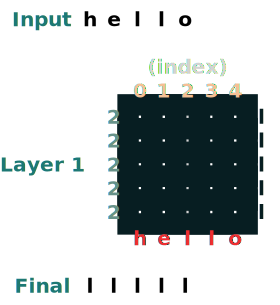

In [8]:
#Select token at index 
def index(i, seq=tokens):
    x = (query(i) == key(indices)).value(seq)
    return x.name("index")
index(2)

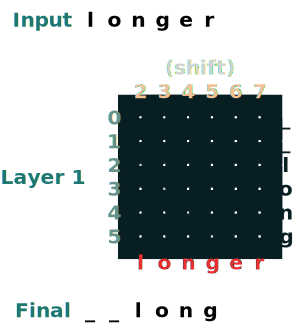

In [9]:
#Shift i token to the right and fill with default token
    #I am unsure how Tracr handles default values in aggregation, I am going to assume it canont be changed with parameter like here so I will do explicitly
        #Nwm there seems to be support for it in Tracr/RASP
            #Nwm nwm Tracr can only default with None or 0 but I solved it

def shift(i=1, default="_", seq=tokens):
    shiftMask = (query(indices) == key(indices+i))
    x = shiftMask.value(seq, default)

    return x.name("shift")
shift(2).input(long)

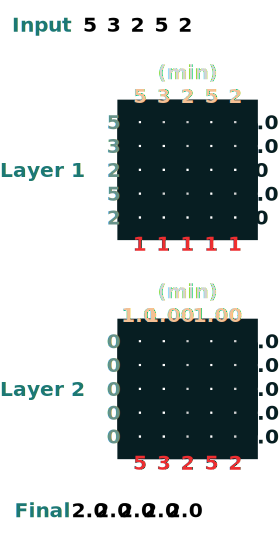

In [10]:
#In the blog they first find the smalest number and then remove duplicates so that only the first of the smalest numbers gets marked
#Using mean aggregation I can skip duplicate logic since the mean of two equal numbers is the number (does add float in that case but it should be fine)

#Return a vector with the smalest number in input
def minimum(seq=tokens):
    invMin = (key(seq) < query(seq)).value(1)   #Marks all values that are not the minimum
    x = (key(invMin) == query(0)).value(seq)    #Computes the mean of all the mimimum values aka the minimum value (This method will not work in Tracr due to aggeregation of non-binary)

    return x.name("min")
minimum()([5,3,2,5,2])

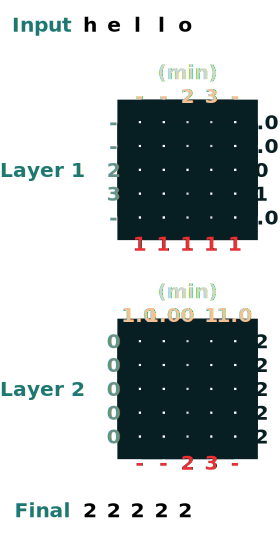

In [11]:
#Some strange parts about this. 
#   99 gets rendered as - while all other numbers seem to be rendered as the number. Programatically I'm guessing it handles - the same as 99
#   The 99 mean that only sequences less than 100 are possible but 99 can be extended
#   If none are found it return 99 which shows as -

#Computes the first index of token 'q'
def first(q, seq=tokens):
    return minimum(where(q==seq, indices, 99)).name("first")
first("l").input("hello")

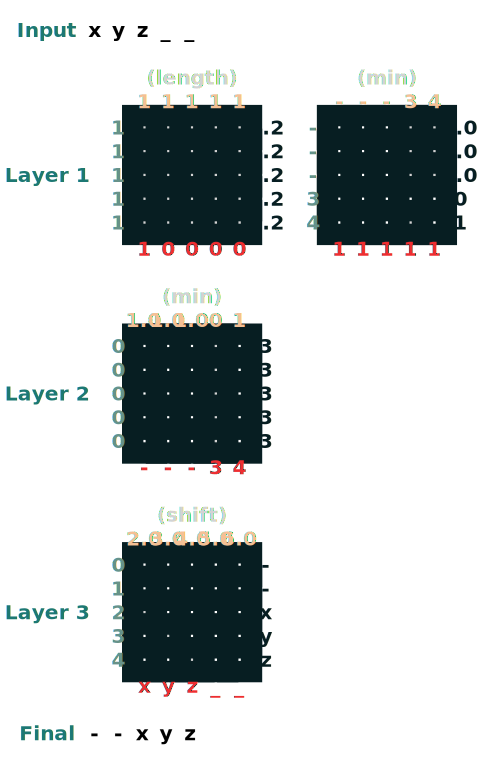

In [12]:
#Right aligns a sequence padded with _ and pads with default
def ralign(default="-", sop=tokens):
    offset = first("_")    #Finds first instance of _
    shifted = shift(length()-offset, default=default)
    return shifted.name("ralign")
ralign()("xyz__")

In [13]:
#In RASP you can use selectors as parameters but I cannot figure out a way to do that in RASPy

def selector_width(sel, seq):
    light0 = indices == 0
    return sel
    or0 = (sel | query((indices) == key(0)))

    return or0

tok = tokens.input("test")
tok
sel = (query(tok) == key(tok))
sel
#selector_width(sel, tok)


TypeError: object of type 'Seq' has no len()

TypeError: object of type 'Seq' has no len()

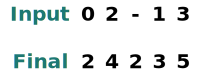

In [14]:
#Histogram (This should be the same as selector_width in numeric situations at least.
#           Also assumes no BOS token with this implementation.)
#           Lazy implementation with boolean combination of selectors since Tracr and RASP has an actual selector_width function
def hist(seq = tokens):
    sel = query(seq) == key(seq)
    firstind = query(0) == key(indices)
    orWidth = 1 / (sel | firstind).value(indices==0)
    andWidth = (sel & firstind).value(indices==0, 0)

    return andWidth + orWidth - 1

#hist()("test")
hist()

def atoi(seq=tokens):
    return seq.map(lambda x: ord(x) - ord('0')) 

op = (atoi(where(tokens == "-", "0", tokens)) + 2)
op.input("02-13")

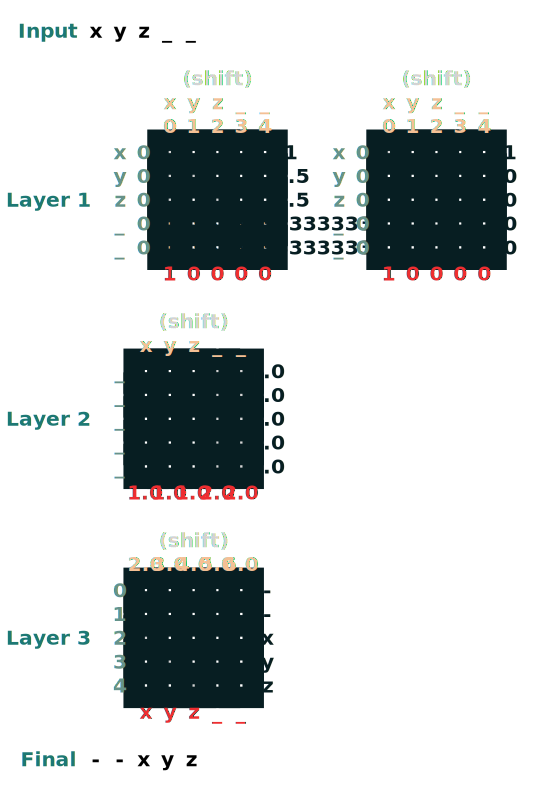

In [15]:
#Right aligns a sequence padded with _ and pads with default (implemented with histogram instead in order to be closer to blog solution)
#It ends up as a more complicated version to do the same thing as the first solution though
def ralignalt(default="-", sop=tokens):
    histogram = hist()
    c = (key(sop) == query("_")).value(histogram)
    x = shift(c, default)
    return x.name("ralign")
ralignalt()("xyz__")

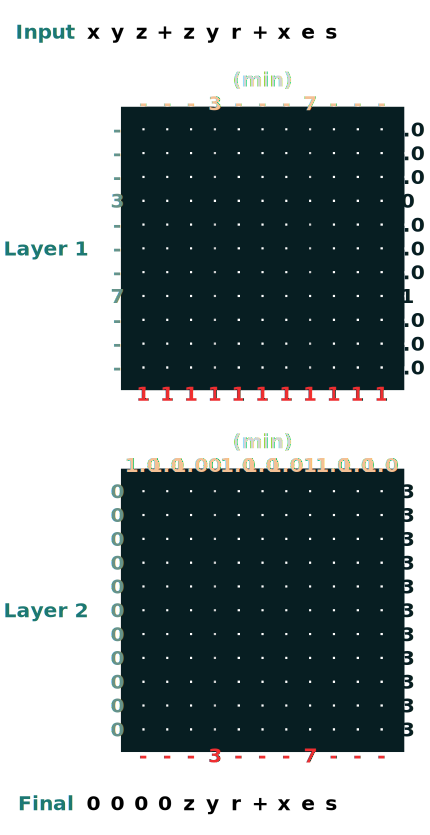

In [20]:
#I intuit that if I can manage to split rework this function to split the computation based on the first instead of the only "v" I could start handling more than one addition/subtraction at a time.
#If I can split based on multiple tokens I could start handling multiple expressions in the same sequence
#Parentheses are intuitively more complicated and would only start making a difference when capable of using division and multiplication simultaneously

#Split the sequence into two around the first v token. If 'takeFirst' is true takes the first part otherwise take the second part. Right aligns and fills with default.
def split(v, takeFirst, default="0", sop=tokens):
    splitInd = first(v)
    #splitInd = (key(sop) == query(v)).value(indices)   #Gives an even better performance than the blog solution but can only be used if v is unique
    if takeFirst:
        return shift(length()-splitInd, default).name("firstSplit")
    return where(indices>splitInd, sop, default).name("secondSplit")
split("+", 0)("xyz+zyr+xes")
#split("+", 1)("xyz+xes")

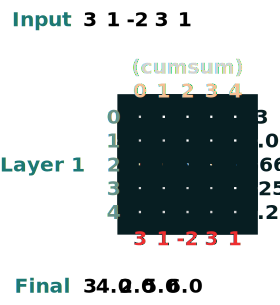

In [21]:
#Cumulative sum
def cumsum(seq=tokens):
    x = ((key(indices) <= query(indices))).value(seq)
    y = x * (indices + 1)
    return y.name("cumsum")
cumsum().input([3, 1, -2, 3, 1])

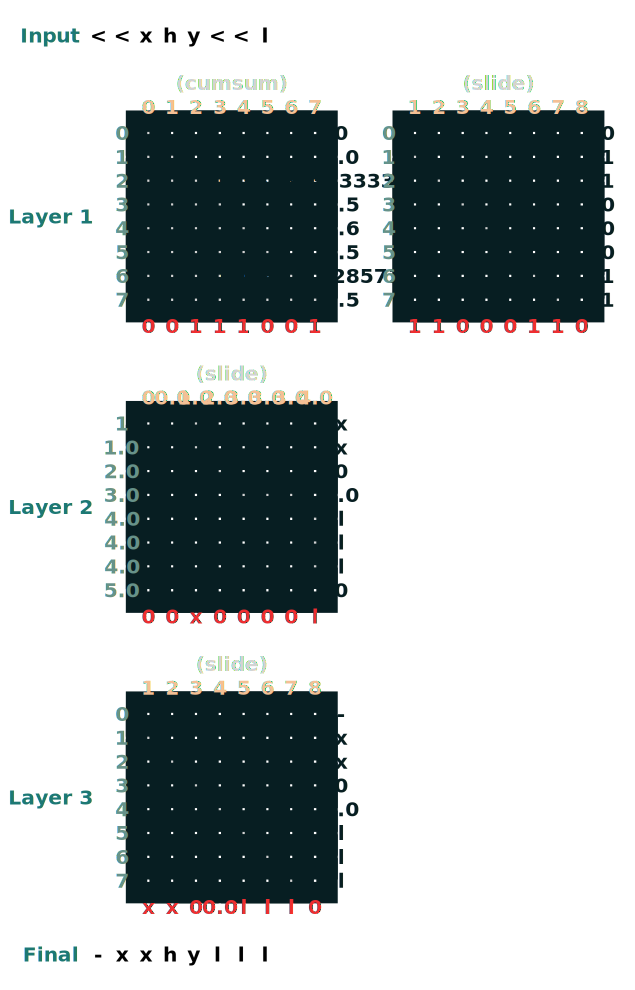

In [24]:
#My found solution feels like it has too many steps. There are not a lot of layers but there are many s-ops (aka complicated(?) FC layer)
#Can be done significantly simpler if we assume only one shift operation but we cannot do that when handling carries

#Replace the < token with duplicates of the token to the right of them
def slide(match, seq=tokens):
    #I need to find the token to the right of <
    #The tricky part is figuring out a method that avoids boolean combination of selectors
    #Turns out the actually tricky part is finding a method which works in Tracr
    
    slideInd = (match != 1) #Match the indices where sliding shall be done

    shiftMask = (query(indices) == key(indices+1))
    shifted = shiftMask.value(slideInd, 0)
    broadcast = (shifted - slideInd) == 1        #Find indices of tokens to be broadcasted

    x = cumsum(match) 
    blocks = (key(x) == query(x + 1))           #The selector finds blocks from where there is a new non < token
    offsetTokens = blocks.value(where(broadcast, seq, 0))

    #Fixes bug if first token in seq is <. It doesn't work atm since RASPy ignores this input and defaults to -. Unsure how RASP/Tracr handles this case
    #Can be fixed by using another where statement after shift instead of relying on default values but the complexity is already getting depressing
        #I don't think this will ever be a problem when handling carries though as the leftmost index can never be a potential carry (In fact it must always be 0)
    firstShiftToken = (key(indices) == query(0)).value(offsetTokens)    
    seq = where(match, seq, shiftMask.value(offsetTokens, firstShiftToken))
    return seq.name("slide")

slide(tokens != "<").input("j<xhy<<l")

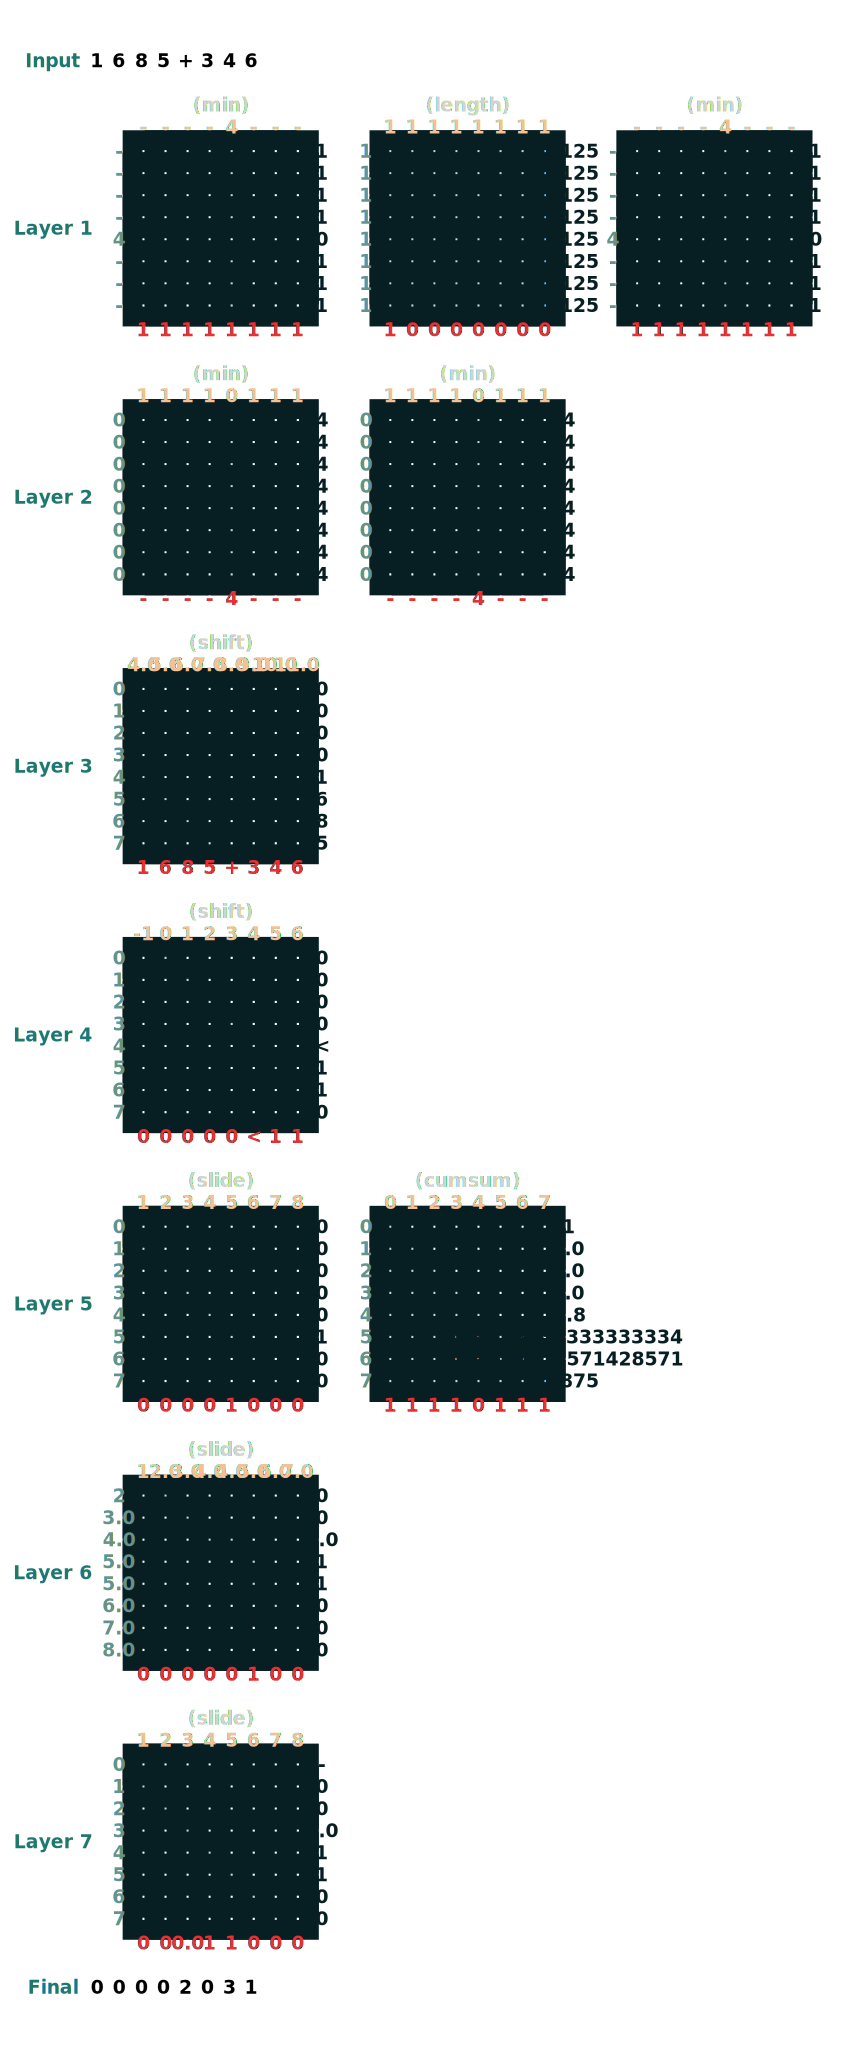

In [18]:
#Add the numbers. Same as in the blog since all the parts work the same.
def add(sop=tokens):
    # 0) Parse and add
    x = atoi(split("+", True, sop=sop)) + atoi(split("+", False, sop=sop))
    # 1) Check for carries 
    gets_carry = shift(-1, "0", where(x > 9, "1", where(x == 9, "<", "0")))
    # 2) Slide carries to their columns - all in one parallel go!                                         
    gets_carry = atoi(slide(gets_carry != "<", gets_carry))
    # 3) Add in carries, and remove overflow from original addition.                                                                                  
    return (x + gets_carry) % 10
add()("1685+346")

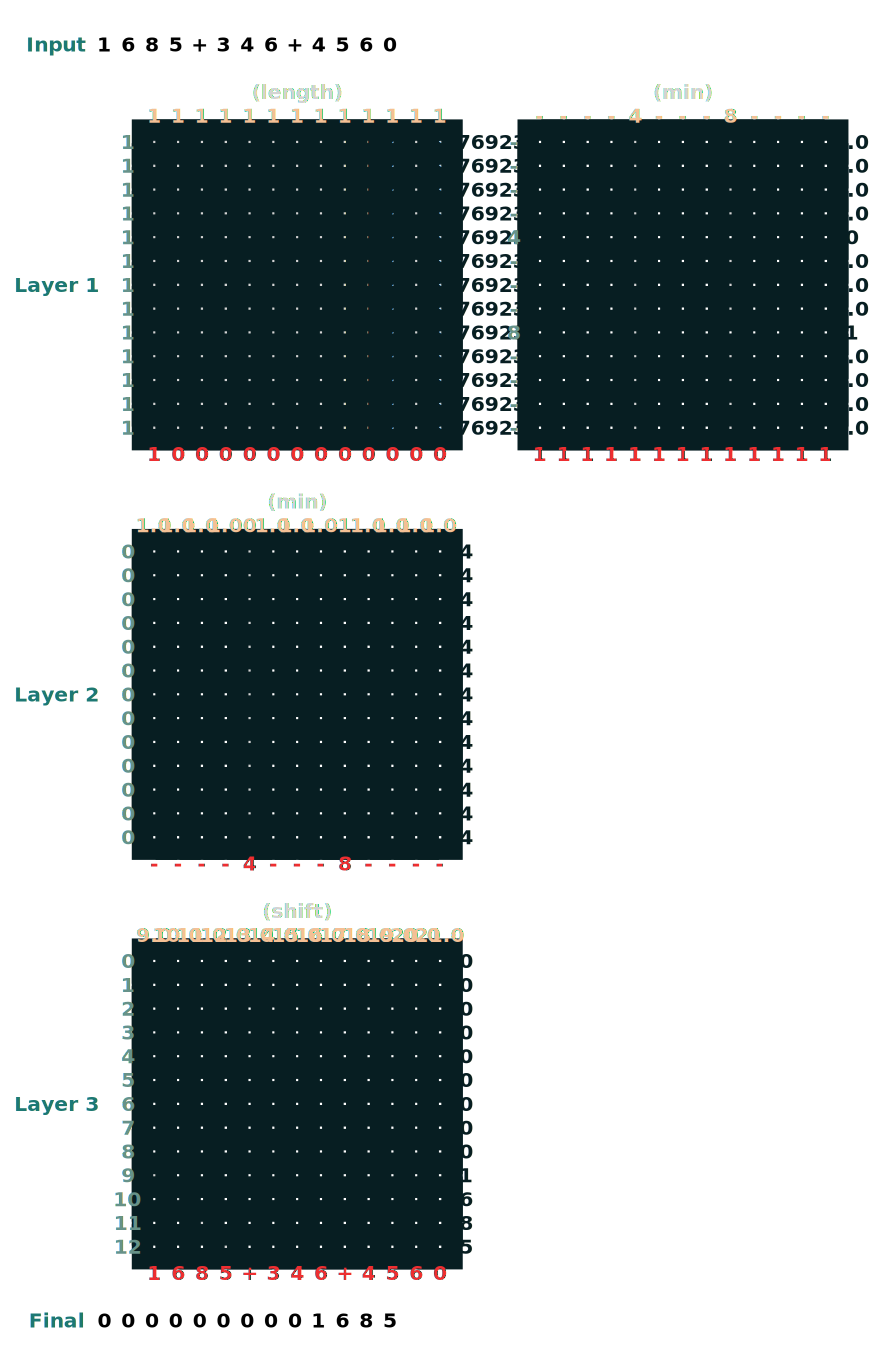

In [28]:
#Returns instances of token v 
#Meant to figure out how many numbers to add but I realized this won't work since it requires a loop after finding out
def countToken(v, seq=tokens):
    return (key(seq) == query(v)).value(hist())

#Adds 'N' numbers (WIP)
def addN(N, seq=tokens):
    terms = [None for i in range(N)]
    temp = [None for i in range(N-1)] #For some reason I cannot seem to overwrite temp to a new temp using a split on temp
    temp[0] = seq

    terms[0] = split('+', True, sop=temp[0]) #=000000001685
    temp[1] = split('+', False, sop=temp[0]) #=00000346+4560   

    terms[1] = split('+', True, sop=indices) #=000000001685
    terms[1] = split('+', True, sop=indices) #=000000001685 It ignores the sop input and does seq instead me thinks, but why??? It does not seem to do that in their add implementation
    return terms[1]

    #for i in range(N-1):
    #    terms[i] = split('+', True, sop=temp)
    #    temp = split('+', False, sop=temp)
    terms[-1]=temp[-1]

    return terms[2]

#Wrapped which calculates the number of terms 
def addMultiple(inputSeq):
    #Count terms    (It does count the terms but since RASP is should be done sequentially without control logic this is simple a shortcut for the transpile function)
    nTerms = round(countToken('+').input(inputSeq).val[0] + 1)
    return addN(nTerms).input(inputSeq)


    # 0) Parse and add
    x = atoi(split("+", True, sop=sop)) + atoi(split("+", False, sop=sop))
    # 1) Check for carries 
    gets_carry = shift(-1, "0", where(x > 9, "1", where(x == 9, "<", "0")))
    # 2) Slide carries to their columns - all in one parallel go!                                         
    gets_carry = atoi(slide(gets_carry != "<", gets_carry))
    # 3) Add in carries, and remove overflow from original addition.                                                                                  
    return (x + gets_carry) % 10
addMultiple("1685+346+4560")

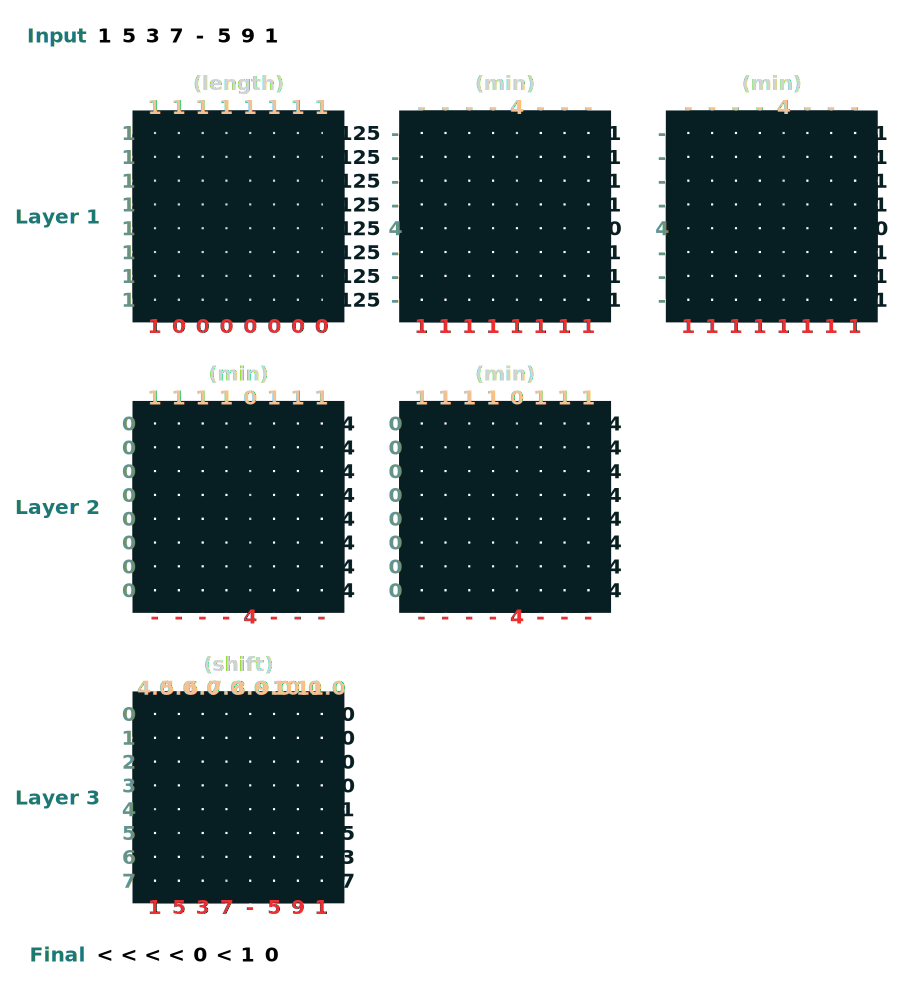

In [29]:
#subtraction (wip)
def subtract(sop=tokens):
    # 0) Parse and subtract
    x = atoi(split("-", True, sop=sop)) - atoi(split("-", False, sop=sop))
    # 1) Check for carries 
    gets_carry = where(x < 0, "1", where(x == 0, "<", "0")) #How to handle that it backfills with 0? I could fill until first "none <" with 0
    # 2) Slide carries to their columns - all in one parallel go! 
    return gets_carry
    return slide(gets_carry != "<", gets_carry)                
    gets_carry = atoi(slide(gets_carry != "<", gets_carry))
    return gets_carry
    # 3) Add in carries, and remove overflow from original addition.                                                                                  
    return (x + gets_carry * 10 + shift(-1,0,gets_carry)) % 10

    # 0) Parse and add
    x = atoi(split("+", True, sop=sop)) + atoi(split("+", False, sop=sop))
    # 1) Check for carries 
    gets_carry = shift(-1, "0", where(x > 9, "1", where(x == 9, "<", "0")))
    # 2) Slide carries to their columns - all in one parallel go!                                         
    gets_carry = atoi(slide(gets_carry != "<", gets_carry))
    # 3) Add in carries, and remove overflow from original addition. 
subtract()("1537-591")